# Starbucks Capstone Project

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [44]:
# Replaced None values by N
genders_dist = profile.gender.fillna('N').value_counts(normalize=True)

In [99]:
genders_dist

M    0.499059
F    0.360529
N    0.127941
O    0.012471
Name: gender, dtype: float64

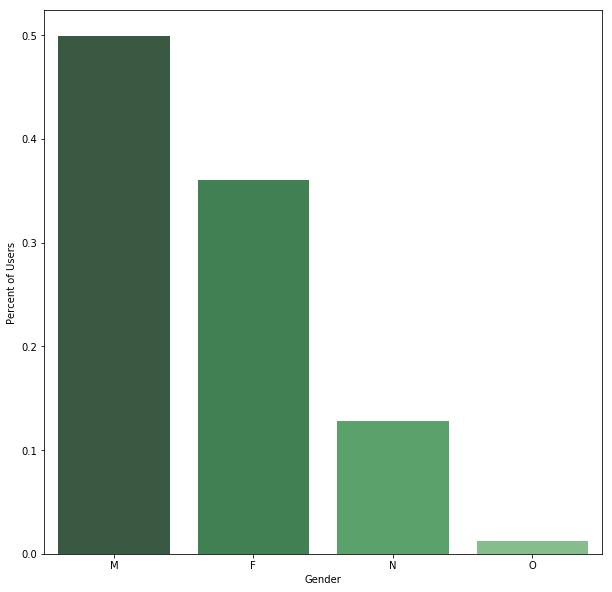

In [59]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.barplot(x=genders_dist.index, y=genders_dist.values, palette="Greens_d")

ax.set_xlabel('Gender')
ax.set_ylabel('Percent of Users')

plt.show()

In [108]:
profile.age[profile['income'].isna()].head()

0    118
2    118
4    118
6    118
7    118
Name: age, dtype: int64

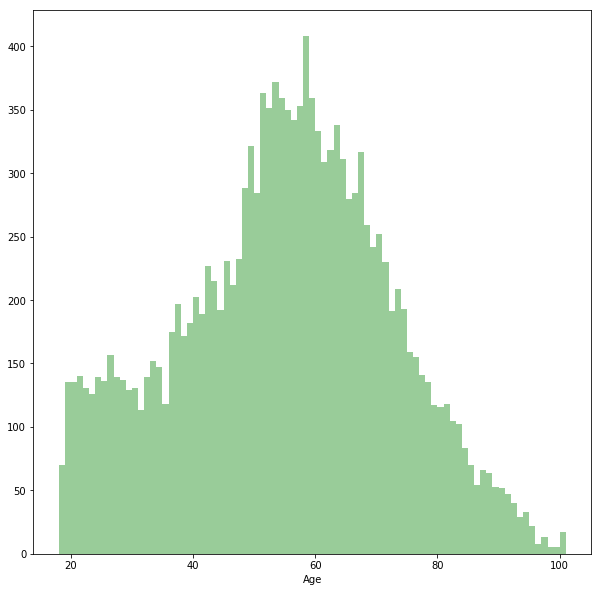

In [103]:
# Don't use value equal to 118 because of NaN values replaced by 118
fig, ax = plt.subplots(figsize = (10, 10))
sns.distplot(profile.age[profile['age'] != 118], bins=83, kde=False, color='g')

ax.set_xlabel('Age')

plt.show()

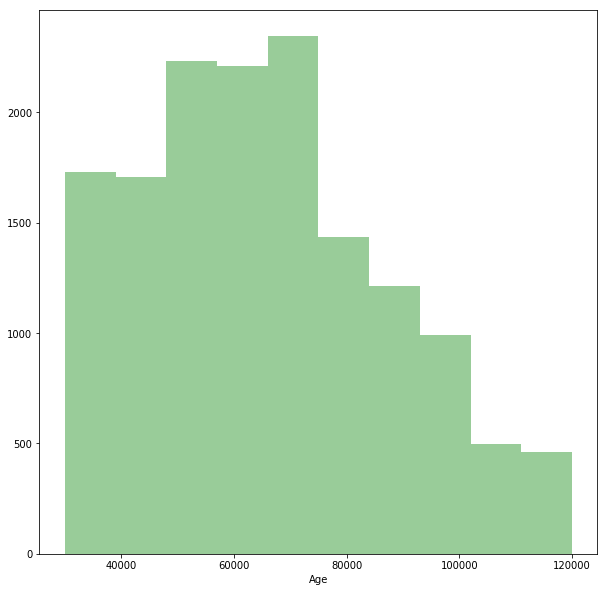

In [89]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.distplot(profile.income[~profile['income'].isna()], bins=10, kde=False, color='g')

ax.set_xlabel('Age')

plt.show()

In [104]:
profile.income.mean()

65404.9915682968

## Data Preprocessing

### Portfolio

In [116]:
portfolio_clean = portfolio.copy()

In [117]:
portfolio_clean

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [118]:
# encoding for channels
portfolio_clean['web'] = portfolio_clean['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio_clean['email'] = portfolio_clean['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio_clean['mobile'] = portfolio_clean['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio_clean['social'] = portfolio_clean['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [125]:
# create dummies for offer_type
offer_types = pd.get_dummies(portfolio_clean['offer_type'])

In [126]:
portfolio_clean = pd.concat([portfolio_clean, offer_types], axis=1, sort=False)

In [128]:
# dropped channels - encoded; dropped offer_type - dummies; dropped informational - we need k-1 columns for dummies
portfolio_clean.drop(['channels', 'offer_type', 'informational'], axis=1, inplace=True)

In [129]:
portfolio_clean

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1


### Profile

In [154]:
profile_clean = profile.copy()

In [180]:
profile_clean.head()

,age,became_member_on,id,income,F,M,N
0,55.0,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,64000.0,0,0,1
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,55.0,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,64000.0,0,0,1
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,55.0,2017-08-04,a03223e636434f42ac4c3df47e8bac43,64000.0,0,0,1


In [155]:
profile_clean.gender = profile_clean.gender.fillna('N')

In [156]:
profile_clean.age = profile_clean.age.apply(lambda x: np.nan if x == 118 else x)

In [157]:
genders = pd.get_dummies(profile_clean['gender'])

In [158]:
profile_clean = pd.concat([profile_clean, genders], axis=1, sort=False)

In [159]:
profile_clean.drop(['gender', 'O'], axis=1, inplace=True)

In [160]:
profile_clean = profile_clean.fillna({'age': profile_clean.age.dropna().median()})

In [161]:
profile_clean = profile_clean.fillna({'income': profile_clean.income.dropna().median()})

In [162]:
profile_clean.became_member_on = pd.to_datetime(profile_clean.became_member_on, format='%Y%m%d')

In [164]:
profile_clean.head()

,age,became_member_on,id,income,F,M,N
0,55.0,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,64000.0,0,0,1
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,55.0,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,64000.0,0,0,1
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,55.0,2017-08-04,a03223e636434f42ac4c3df47e8bac43,64000.0,0,0,1


### Transcript

In [169]:
transcript_clean = transcript.copy()

In [171]:
transcript_clean.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [172]:
transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x.get('offer_id') or x.get('offer id'))

In [174]:
transcript_clean['amount'] = transcript_clean['value'].apply(lambda x: x.get('amount'))

In [177]:
transcript_clean = transcript_clean.drop(['value'], axis=1)

In [183]:
transcript_test = transcript_clean.sort_index().merge(portfolio[["id", "offer_type", "difficulty", "duration"]], left_on="offer_id", right_on="id", how="left")

In [185]:
transcript_test.sort_values(by=['person', 'time'])

,event,person,time,offer_id,amount,id,offer_type,difficulty,duration
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None,22.16,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,informational,0.0,4.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,informational,0.0,4.0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0
168412,transaction,0009655768c64bdeb2e877511632db8f,414,None,8.57,NaN,NaN,NaN,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0


In [186]:
transcript_clean.sort_values(by=['person', 'time'])

,event,person,time,offer_id,amount
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,None,22.16
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,None,8.57
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN
